# Определние перспективного тарифа для телеком-компании

##  Общая информация 

<b> Задача: <b> 

Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Вам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

**Описание тарифов:**
    
**Тариф «Смарт»**

1. **Ежемесячная плата:** 550 рублей


2. Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика


3. Стоимость услуг сверх тарифного пакета:

    **минута разговора:** 3 рубля
    
    **сообщение:** 3 рубля
       
    **1 Гб интернет-трафика:** 200 рублей
    

**Тариф «Ультра»**
    
1. **Ежемесячная плата:** 1950 рублей


2. Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика


3. Стоимость услуг сверх тарифного пакета:

    **минута разговора:** 1 рубль
    
    **сообщение:** 1 рубль
    
    **1 Гб интернет-трафика:** 150 рублей

## Чтение данных

In [264]:
#импортируем библиотеки 
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

from scipy import stats 

In [265]:
#сохраняем датасеты 
users = pd.read_csv('/Users/denisslobodyanyuk/Desktop/датасеты яндекса/users.csv', parse_dates=['churn_date', 'reg_date'])
calls = pd.read_csv('/Users/denisslobodyanyuk/Desktop/датасеты яндекса/calls.csv', parse_dates=['call_date'])
messages = pd.read_csv('/Users/denisslobodyanyuk/Desktop/датасеты яндекса/messages.csv', parse_dates=['message_date'])
internet = pd.read_csv('/Users/denisslobodyanyuk/Desktop/датасеты яндекса/internet.csv', parse_dates=['session_date'])
tariffs = pd.read_csv('/Users/denisslobodyanyuk/Desktop/датасеты яндекса/tariffs.csv')

In [314]:
#построим функции для графиков 
def histplot(data, column):
    fig = px.histogram(data, x=column, title=f'Histogam of {column}')
    return fig 

def pieplt(data, column, title):
    labels = data[column].value_counts().index
    values = data[column].value_counts().values
    fig = px.pie(values=values, names=labels, title=title)
    fig.show()
    
def pieplt_matplot(data, column, title):
    labels = data[column].value_counts().index
    values = data[column].value_counts().values
    explode = (0.1, 0, 0.15, 0, 0)
    fig, ax = plt.subplots()
    ax.pie(values, labels=labels, autopct='%1.1f%%', shadow=True, wedgeprops={'lw':1, 'ls':'--','edgecolor':"k"}, rotatelabels=True)
    ax.axis("equal")
    plt.title(title)

## Подготовка данных

### пользователи

In [267]:
users.head()#выведем первые 5 строк

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaT,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaT,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaT,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [268]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   age         500 non-null    int64         
 2   churn_date  38 non-null     datetime64[ns]
 3   city        500 non-null    object        
 4   first_name  500 non-null    object        
 5   last_name   500 non-null    object        
 6   reg_date    500 non-null    datetime64[ns]
 7   tariff      500 non-null    object        
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


####  Вывод: 

Пропуски в столбце `churn_date` не являютя аномалией, так как по условию это значит, что тариф ещё действовал на момент выгрузки данных.

### звонки 

In [269]:
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [270]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         202607 non-null  object        
 1   call_date  202607 non-null  datetime64[ns]
 2   duration   202607 non-null  float64       
 3   user_id    202607 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 6.2+ MB


In [271]:
#создадим функцию приведем к целочисленному типу данных
def to_int(data):
    data['id'] = data['id'].astype('int16')
    
to_int(calls)

In [272]:
#округлим время звонка
calls['duration'] = calls['duration'].apply(np.ceil).astype('int')

In [273]:
#график длительности звонков 
histplot(calls, 'duration')

####  Вывод:

Самое частое значение - это 0. Затем чаще всего происходили звонки 6-7 минут

### сообщения 

In [274]:
messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [275]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            123036 non-null  object        
 1   message_date  123036 non-null  datetime64[ns]
 2   user_id       123036 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 2.8+ MB


In [276]:
#приведем к целочисленному типу данных 
to_int(messages)

####  Вывод:

Пропуски отсутствуют, тип данных изменили на `int`

### Интернет 

In [277]:
internet.head()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


In [278]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Unnamed: 0    149396 non-null  int64         
 1   id            149396 non-null  object        
 2   mb_used       149396 non-null  float64       
 3   session_date  149396 non-null  datetime64[ns]
 4   user_id       149396 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 5.7+ MB


In [279]:
to_int(internet)

#### Вывод:

Пропусков нет, тип данных также изменили

### Тарифы 

In [280]:
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [281]:
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


In [282]:
#переименуем столбец для последующего соединения 
tariffs = tariffs.rename(columns={'tariff_name': 'tariff'})

#переведём мг в гб
tariffs['gb_per_month_included'] = (tariffs['mb_per_month_included'] / 1024).astype('int')
tariffs.drop(columns=['mb_per_month_included'], inplace=True)

####  Вывод: 

Пропусков никаких нет. Изменили название столбца и привели к гигобайтам.

## Расчеты дополнительных параметров 

**Посчитайте для каждого пользователя:**

1. количество сделанных звонков и израсходованных минут разговора по месяцам;
2. количество отправленных сообщений по месяцам;
3. объем израсходованного интернет-трафика по месяцам;
4. помесячную выручку с каждого пользователя (вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножьте на значение из тарифного плана; прибавьте абонентскую плату, соответствующую тарифному плану).


In [283]:
#создаем функцию для выделения месяца 
def get_month(data, column):
    data['month'] = data[column].dt.month
    
get_month(calls, 'call_date')
get_month(messages, 'message_date')
get_month(internet, 'session_date')

In [284]:
#количество сделанных звонков и израсходованных минут разговора по месяцам
calls_by_month = calls.groupby(['user_id', 'month']) \
                       .agg({'duration': 'sum',
                             'id': 'count'}).reset_index().rename(columns={'duration': 'duration_by_month',
                                                                           'id': 'calls_by_month'})
                        
calls_by_month.head()

,user_id,month,duration_by_month,calls_by_month
0,1000,5,159,22
1,1000,6,172,43
2,1000,7,340,47
3,1000,8,408,52
4,1000,9,466,58


In [285]:
#количество отправленных сообщений по месяцам
messages_by_month = messages.groupby(['user_id', 'month']) \
                       .agg({'id': 'count'}) \
                       .reset_index() \
                       .rename(columns={'id': 'messages_by_month'})

messages_by_month.head()

,user_id,month,messages_by_month
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57


In [286]:
#объем израсходованного интернет-трафика по месяцам
internet_by_month = internet.groupby(['user_id', 'month']) \
                            .agg({'mb_used': 'sum'}) \
                            .reset_index() 
internet_by_month['gb_used_by_month'] = (internet_by_month['mb_used'] / 1024).apply(np.ceil).astype('int')
internet_by_month.drop(columns=['mb_used'], inplace=True)
internet_by_month.head()

,user_id,month,gb_used_by_month
0,1000,5,3
1,1000,6,23
2,1000,7,14
3,1000,8,14
4,1000,9,15


#### помесячную выручку с каждого пользователя


In [287]:
#соединим таблицы 
user_data = calls_by_month.merge(messages_by_month, on=['user_id', 'month'], how='outer') \
                          .merge(internet_by_month, on=['user_id', 'month'], how='outer')

user_data = user_data.merge(users, on='user_id', how='left').merge(tariffs, on='tariff', how='left')
user_data.head()

,user_id,month,duration_by_month,calls_by_month,messages_by_month,gb_used_by_month,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,gb_per_month_included
0,1000,5,159.0,22.0,22.0,3.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,3000,1950,150,1,1,30
1,1000,6,172.0,43.0,60.0,23.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,3000,1950,150,1,1,30
2,1000,7,340.0,47.0,75.0,14.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,3000,1950,150,1,1,30
3,1000,8,408.0,52.0,81.0,14.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,3000,1950,150,1,1,30
4,1000,9,466.0,58.0,57.0,15.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,3000,1950,150,1,1,30


In [288]:
user_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   user_id                3214 non-null   int64         
 1   month                  3214 non-null   int64         
 2   duration_by_month      3174 non-null   float64       
 3   calls_by_month         3174 non-null   float64       
 4   messages_by_month      2717 non-null   float64       
 5   gb_used_by_month       3203 non-null   float64       
 6   age                    3214 non-null   int64         
 7   churn_date             187 non-null    datetime64[ns]
 8   city                   3214 non-null   object        
 9   first_name             3214 non-null   object        
 10  last_name              3214 non-null   object        
 11  reg_date               3214 non-null   datetime64[ns]
 12  tariff                 3214 non-null   object        
 13  mes

In [289]:
#заполним пропуски 
user_data.fillna({'duration_by_month': 0, 'calls_by_month': 0, 'messages_by_month': 0, 'gb_used_by_month': 0}, inplace=True)

In [290]:
#создадим функцию для тарифа 
def tariff_excess(row):
    calls = (row['duration_by_month'] - row['minutes_included']) * row['rub_per_minute']
    messages = (row['messages_by_month'] - row['messages_included']) * row['rub_per_message']
    internet = (row['gb_used_by_month'] - row['gb_per_month_included']) * row['rub_per_gb']
    excess = 0
    
    for value in [calls, messages, internet]:
        if value > 0:
            excess += value
    return excess
    
user_data['revenue'] = user_data.apply(tariff_excess, axis=1) + user_data['rub_monthly_fee']

## Анализ данных

Опишите поведение клиентов оператора, исходя из выборки. 

Сколько **минут разговора**, **сколько сообщений** и какой **объём интернет-трафика** требуется пользователям каждого тарифа в месяц? 

Посчитайте **среднее количество, дисперсию и стандартное отклонение.** Постройте гистограммы. Опишите распределения.

In [291]:
#создадим выборки длля тарифов 
smart = user_data.query('tariff == "smart"')
ultra = user_data.query('tariff == "ultra"')

### минуты разговора

In [292]:
#длительность звонков 
user_data.groupby('tariff').agg({'duration_by_month': ['mean', 'var', 'std']}).round(2)

duration_by_month                   
                    mean        var     std
tariff                                     
smart             417.93   36219.32  190.31
ultra             526.62  100873.63  317.61

In [293]:
#количество звонков 
user_data.groupby('tariff').agg({'calls_by_month': ['mean', 'var', 'std']}).round(2)

calls_by_month                
                 mean      var    std
tariff                               
smart           58.46   672.88  25.94
ultra           73.39  1928.69  43.92

In [294]:
histplot(smart, 'duration_by_month').show()


histplot(ultra, 'duration_by_month').show()

In [295]:
#построим линейный график средней длительности звонков 
mean_duration = user_data.pivot_table(index=['month', 'tariff'], values='duration_by_month', aggfunc='mean').reset_index()

mean_duration_line = px.line(mean_duration, x='month', y='duration_by_month', color='tariff', title='Mean calls duration by month')
mean_duration_line.show()

In [296]:
#построим линейный график среднего количества звонков 
mean_calls = user_data.pivot_table(index=['month', 'tariff'], values='calls_by_month', aggfunc='mean').reset_index()

mean_calls_line = px.line(mean_calls, x='month', y='calls_by_month', color='tariff', title='Mean calls amount by month')
mean_calls_line.show()

#### Выводы:

1. Половина пользователей тарифа "смарт" практически полность используют доступные минуты

2. Самый пик количества звонков и их длительности у обоих тарифов происходит в декабре

3. В среднем количество звонков за месяц больше у тарифа "смарт"

4. На гистограммах наблюдается нормальное распределение 

### сообщения 

In [297]:
user_data.groupby('tariff').agg({'messages_by_month': ['mean', 'var', 'std']}).round(2)

messages_by_month                
                    mean      var    std
tariff                                  
smart              33.38   796.81  28.23
ultra              49.36  2285.27  47.80

In [298]:
histplot(smart, 'messages_by_month').show()


histplot(ultra, 'messages_by_month').show()

In [299]:
#построим линейный график среднего количества сообщений
mean_messages = user_data.pivot_table(index=['month', 'tariff'], values='messages_by_month', aggfunc='mean').reset_index()

mean_messages_line = px.line(mean_messages, x='month', y='messages_by_month', color='tariff', title='Mean messages by month')
mean_messages_line.show()

#### Выводы:

1. На гистограммах не совсем нормальное распределение, большая часть пользователей отправляет 0-9 сообщений в месяц

2. В тарифе "ультра" происходит более резкий рост количества сообщений, начиная со 2 месяца

3. В среднем пользователи тарифа "ультра" отправляют на 16 сообщений в месяц больше

### объём интернет трафика 

In [300]:
user_data.groupby('tariff').agg({'gb_used_by_month': ['mean', 'var', 'std']}).round(2)

gb_used_by_month             
                   mean    var   std
tariff                              
smart             16.33  33.03  5.75
ultra             19.49  97.09  9.85

In [301]:
histplot(smart, 'gb_used_by_month').show()


histplot(ultra, 'gb_used_by_month').show()

In [302]:
mean_internet = user_data.pivot_table(index=['month', 'tariff'], values='gb_used_by_month', aggfunc='mean').reset_index()

mean_internet_line = px.line(mean_internet, x='month', y='gb_used_by_month', color='tariff', title='Mean gb used by month')
mean_internet_line.show()

#### Выводы:

1. На графиках видно нормальное распределение 

2. В среднем пользователи тарифа "ультра" используют немного больше гигобайт в месяц

3. У обоих тарифов резкий рост происходит с начала года по 3 месяц 

4. Пользователям тарифа "смарт" недостаточно 15 гб трафика: в 9 месяцах среднее количество использованных гб в месяц превышает 15

##  Проверка гипотез

1. средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются
2. средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

### средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются

**Нулевая гипотеза:** средние выручки тарифов одинаковы

**Альтернативная гипотеза:** средние выручки тарифов различаются 

 Уровень значимости: *a = 5%*

In [303]:
#используем ttest 
alpha = 0.05
results = stats.ttest_ind(smart['revenue'], ultra['revenue'], equal_var=False)

print('p-значение равно', results.pvalue)

if results.pvalue < alpha:
    print('Имеются основания отвергнуть нулевую гипотезу')
else: 
    print('Нет оснований отвергнуть нулевую гипотезу')

p-значение равно 4.2606313931076085e-250
Имеются основания отвергнуть нулевую гипотезу


#### Вывод:

Используя ttest, мы можем сделать вывод, что средние выручки тарифов "смарт" и "ультра" не одинаковы.

### средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

**Нулевая гипотеза:** средние выручки пользователей из Москвы и пользователей из других регионов одинаковы

**Альтернативная гипотеза:** средние выручки пользователей из Москвы и пользователей из других регионов различны

Уровень значимости: *a = 5%*

In [304]:
#создадим столбец с регионом 
user_data['region'] = np.where(user_data['city'] == 'Москва', 'Москва', 'Другие регионы')

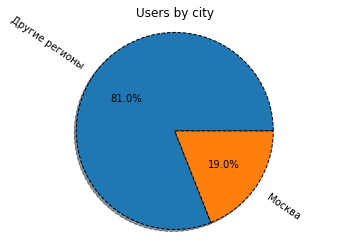

In [315]:
pieplt_matplot(user_data, 'region', 'Users by city')

In [316]:
#проводим ttest 
moscow = user_data.query('region == "Москва"')
regions = user_data.query('region == "Другие регионы"')

results = stats.ttest_ind(moscow['revenue'], regions['revenue'], equal_var=False)
print('p-значение равно', results.pvalue)

if results.pvalue < alpha:
    print('Имеются основания отвергнуть нулевую гипотезу')
else: 
    print('Нет оснований отвергнуть нулевую гипотезу')

p-значение равно 0.5257376663729298
Нет оснований отвергнуть нулевую гипотезу


####  Вывод: 

1. С вероятностью 52% результат может быть получен результат нулевой гипотезы

2. Мы можем сделать предположение, что в итоге средние выручки пользователей из Москвы и других регионов равны (так как мы не можем отвергнуть нулевую гипотезу) 

## Общий вывод

1. Мы рассчитали  дополнительные параметры(количество сделанных звонков в месяц, отправленных сообщений и т.д.)

2. Средняя ежемесячная выручка с пользователя тарифа "ультра" на 782 руб. больше, чем с тарифа "смарт"

3. Большое влияние на выручку оказывет объём интернет-трафика

4. Мы увидели, что пользователям тарифа "смарт" не хватает 15гб интернет трафика

5. Также поняли, что сообщения не пользуются популярностью у обоих тарифов 

6. Также мы провели ttest для проверки гипотез и решили, что средние выручки тарифов различны, но выручка пользователей из Москвы и других регионов одинаковы 

7. Тарифом "смарт" пользуется большее количество людей, совершается большее количество звонков. В итоге, большую часть выручки приносит тариф "смарт"

Я могу сделать вывод, что для компании тариф "смарт" более выгодный, так как он приносит большую часть выручки и им пользуется большее количество пользователей. Также я бы посоветовал добавить больше объёма интернет-трафика в тариф "смарт".